# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Домашнее задание


**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df_train = pd.read_csv('/home/data/netology_ml/data/hw1 (decision trees)/train.csv')
df_test = pd.read_csv('/home/data/netology_ml/data/hw1 (decision trees)/test.csv')

In [3]:
df_train['WasTrain'] = True
df_test['WasTrain'] = False

In [4]:
df_full = pd.concat([df_train, df_test])
df_full.head()

Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  WasTrain  
0       3    male      1       0.0         A/5 21171      True  
1       1  female      1       1.0          PC 17599      True  
2       3  female      0       1.0  STON/O2. 3101282      True  
3       1  female      1       1.0            113803      True  
4       3    male      0       0.0            373450      True

### 1. Знакомство
Познакомимся с данными

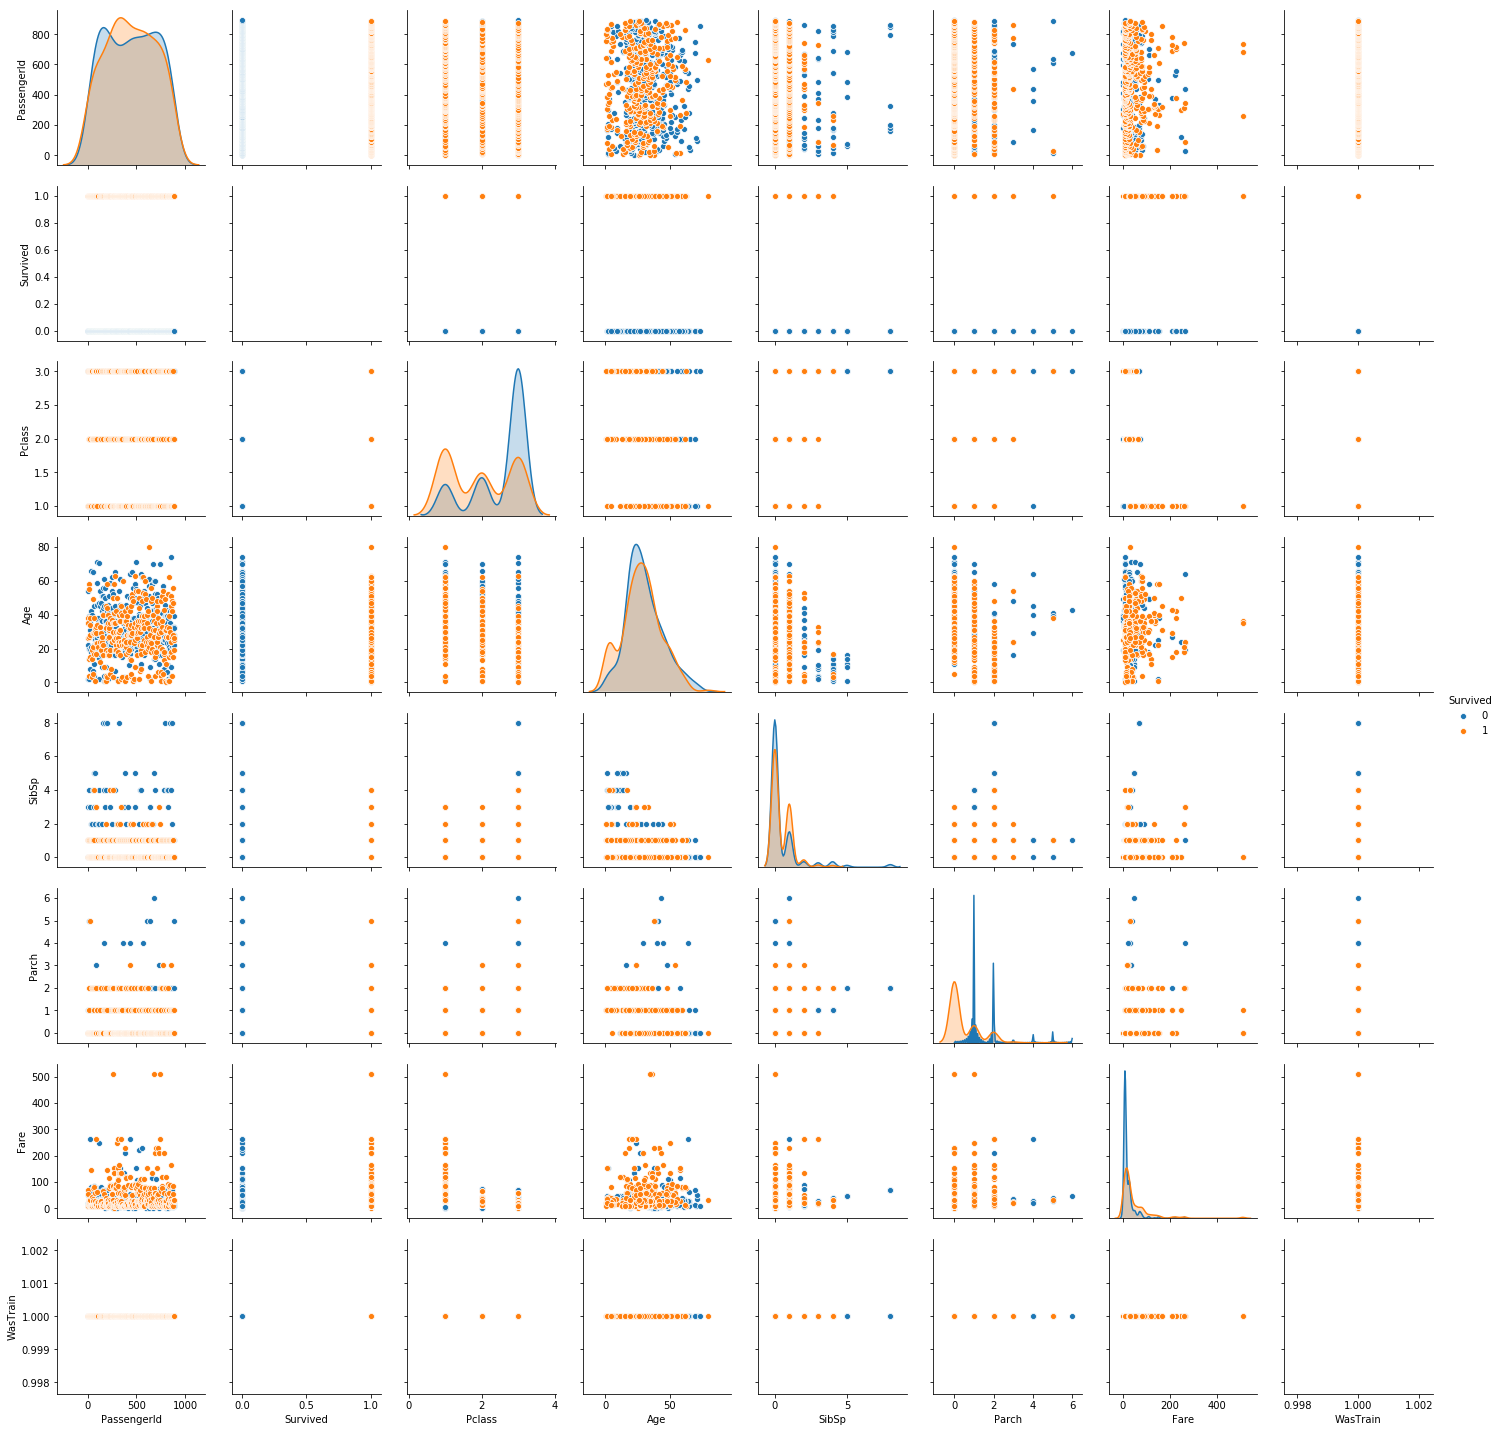

In [5]:
sns.pairplot(df_train, hue='Survived')

Ивлечем генератив из имени в отдельную фичу

In [6]:
df_full['Title'] = df_full.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())

In [7]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

In [8]:
df_full['Title'] = df_full.Title.map(newtitles)

В номере кабины содержится сведения о палубе. Уверен, эти сведения нам также пригодятся.

![Pic](https://upload.wikimedia.org/wikipedia/commons/8/84/Titanic_cutaway_diagram.png)

In [9]:
df_full.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [10]:
def deck_extract(row):
    try:
        return row.Cabin[0]
    except:
        return 'Unknown'

In [11]:
df_full['Deck'] = df_full.apply(lambda x: deck_extract(x), axis=1)

Text(0.5,1,'Age by Title')

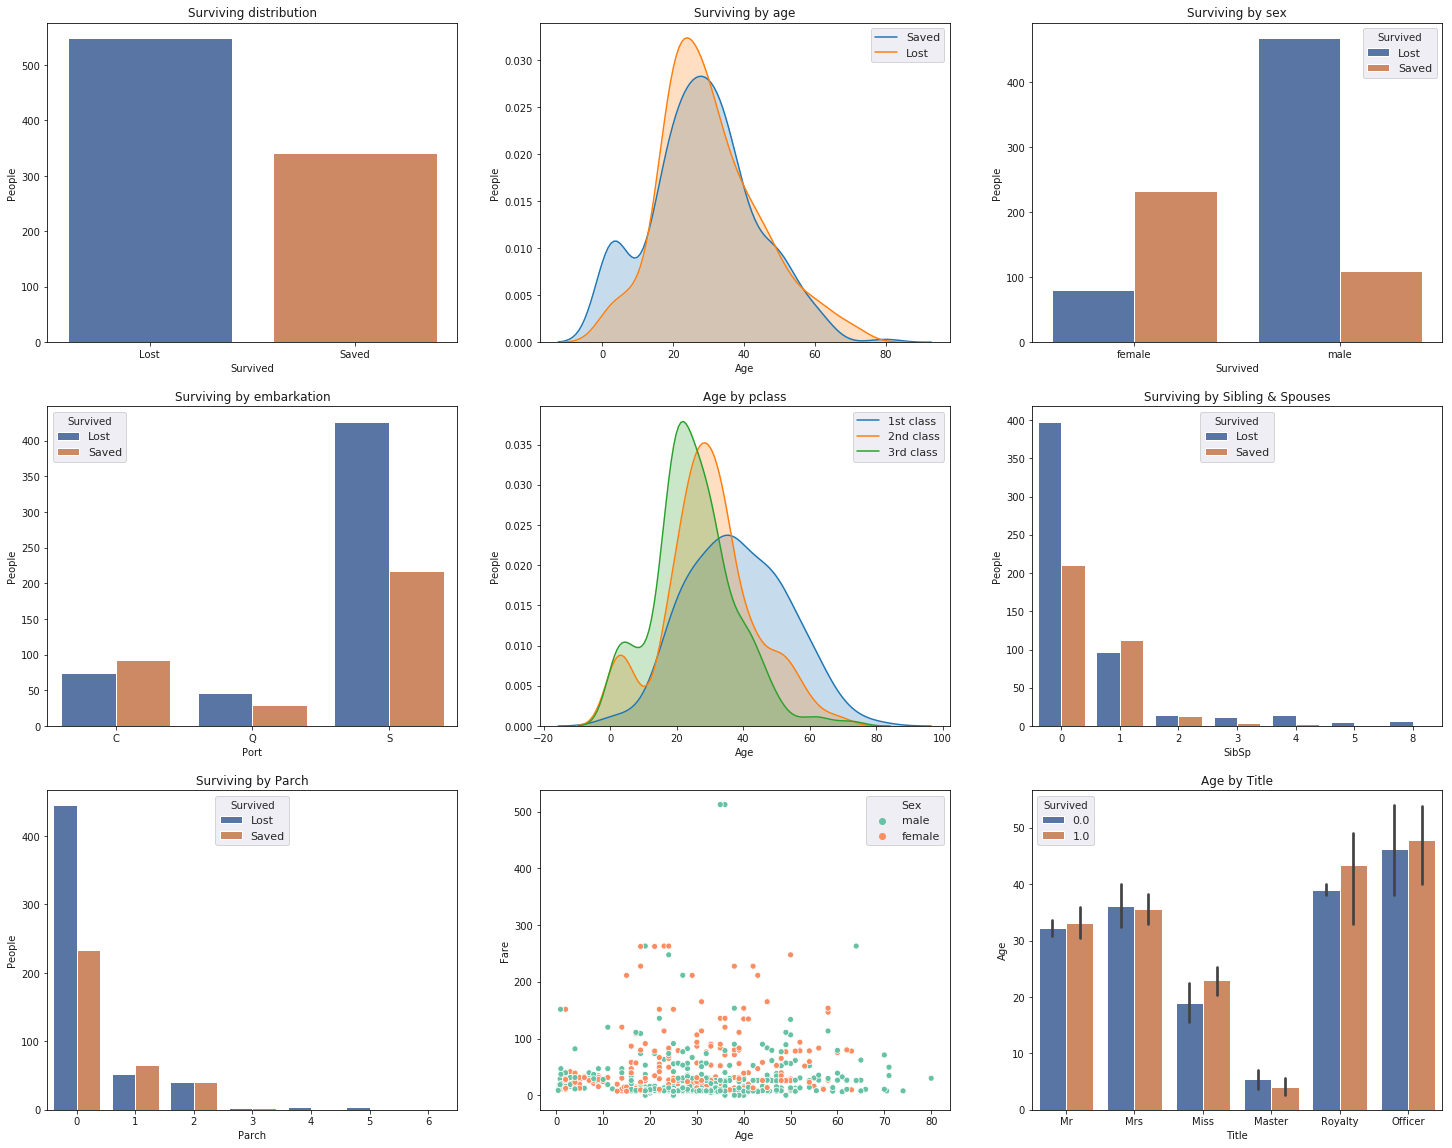

In [12]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(25, 20)

sns.set()
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.color_palette(flatui)

plt_survived = df_train.groupby(by='Survived').count().reset_index()
plt_survived.Survived = plt_survived.Survived.map({0: 'Lost', 1: 'Saved'})
sns.barplot(x='Survived', y='PassengerId', data=plt_survived, ax=ax[0][0]).set_title('Surviving distribution')
ax[0][0].set(xlabel='Survived', ylabel='People')

plt_age = df_train[~df_train.Age.isna()]
plt_age_1 = plt_age[plt_age.Survived == 1]
plt_age_0 = plt_age[plt_age.Survived == 0]
sns.kdeplot(plt_age_1.Age, shade=True, label = 'Saved', ax=ax[0][1]).set_title('Surviving by age')
sns.kdeplot(plt_age_0.Age, shade=True, label = 'Lost', ax=ax[0][1])
ax[0][1].set(xlabel='Age', ylabel='People')

plt_sex = df_train.groupby(by=['Survived' , 'Sex']).count().reset_index()
plt_sex.Survived = plt_sex.Survived.map({0: 'Lost', 1: 'Saved'})
sns.barplot(x='Sex', y='PassengerId', hue='Survived', data=plt_sex, ax=ax[0][2]).set_title('Surviving by sex')
ax[0][2].set(xlabel='Survived', ylabel='People')

plt_embarked = df_train.groupby(by=['Survived' , 'Embarked']).count().reset_index()
plt_embarked.Survived = plt_embarked.Survived.map({0: 'Lost', 1: 'Saved'})
sns.barplot(x='Embarked', y='PassengerId', hue='Survived', data=plt_embarked, ax=ax[1][0]).set_title('Surviving by embarkation')
ax[1][0].set(xlabel='Port', ylabel='People')

plt_age = df_train[~df_train.Age.isna()]
plt_age_class1 = plt_age[plt_age.Pclass == 1]
plt_age_class2 = plt_age[plt_age.Pclass == 2]
plt_age_class3 = plt_age[plt_age.Pclass == 3]
sns.kdeplot(plt_age_class1.Age, shade=True, label = '1st class', ax=ax[1][1]).set_title('Age by pclass')
sns.kdeplot(plt_age_class2.Age, shade=True, label = '2nd class', ax=ax[1][1])
sns.kdeplot(plt_age_class3.Age, shade=True, label = '3rd class', ax=ax[1][1])
ax[1][1].set(xlabel='Age', ylabel='People')

plt_sibsp = df_train.copy()
plt_sibsp.SibSp = plt_sibsp.SibSp.map({0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'})
plt_sibsp.Survived = plt_sibsp.Survived.map({0: 'Lost', 1: 'Saved'})
plt_sibsp = plt_sibsp.groupby(by=['Survived' , 'SibSp']).count().reset_index()
sns.barplot(x='SibSp', y='PassengerId', hue='Survived', data=plt_sibsp, ax=ax[1][2]).set_title('Surviving by Sibling & Spouses')
ax[1][2].set(xlabel='SibSp', ylabel='People')

plt_parch = df_train.copy()
plt_parch.Parch = plt_parch.Parch.map({0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'})
plt_parch.Survived = plt_parch.Survived.map({0: 'Lost', 1: 'Saved'})
plt_parch = plt_parch.groupby(by=['Survived' , 'Parch']).count().reset_index()
sns.barplot(x='Parch', y='PassengerId', hue='Survived', data=plt_parch, ax=ax[2][0]).set_title('Surviving by Parch')
ax[2][0].set(xlabel='Parch', ylabel='People')

sns.scatterplot(x='Age', y='Fare', hue='Sex', data=df_train, palette='Set2', ax=ax[2][1])

sns.barplot(x='Title', y='Age', hue='Survived', data=df_full, ax=ax[2][2]).set_title('Age by Title')

[Text(0,0.5,'People'), Text(0.5,0,'Deck')]

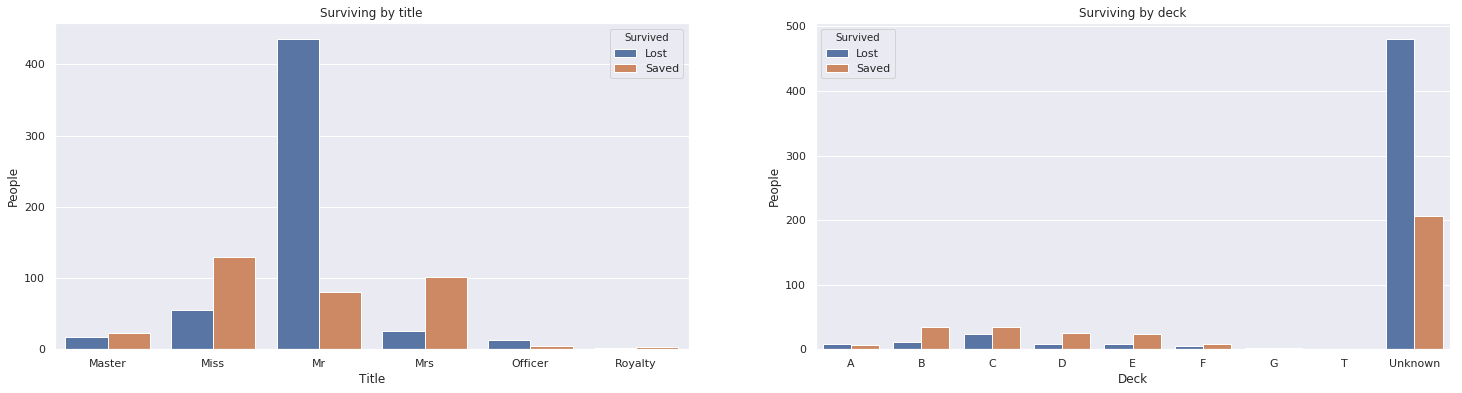

In [13]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(25, 6)

sns.set()
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.color_palette(flatui)

plt_title = df_full[df_full['WasTrain']].groupby(by=['Survived' , 'Title']).count().reset_index()
plt_title.Survived = plt_title.Survived.map({0: 'Lost', 1: 'Saved'})
sns.barplot(x='Title', y='PassengerId', hue='Survived', data=plt_title, ax=ax[0]).set_title('Surviving by title')
ax[0].set(xlabel='Title', ylabel='People')

plt_deck = df_full[df_full['WasTrain']].groupby(by=['Survived' , 'Deck']).count().reset_index()
plt_deck.Survived = plt_deck.Survived.map({0: 'Lost', 1: 'Saved'})
sns.barplot(x='Deck', y='PassengerId', hue='Survived', data=plt_deck, ax=ax[1]).set_title('Surviving by deck')
ax[1].set(xlabel='Deck', ylabel='People')

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
WasTrain       1309 non-null bool
Title          1309 non-null object
Deck           1309 non-null object
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 194.7+ KB


In [15]:
df_full.describe()

Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027   655.000000     2.294882   
std      14.413493    51.758668     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.895800     0.000000   328.000000     2.000000   
50%      28.000000    14.454200     0.000000   655.000000     3.000000   
75%      39.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

             SibSp    Survived  
count  1309.000000  891.000000  
mean      0.498854    0.383838  
std       1.041658    0.486592  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    1.000000  
max       8.000000    1.000000

### 2. Пропуски
В датасете много пропущенных значений. Поработаем с ними.

In [16]:
df_full.Embarked.fillna(df_full.Embarked.mode()[0], inplace=True)

In [17]:
df_full.Fare.fillna(df_full.Fare.mean(), inplace=True)

Много пропусков в переменной Age. Предварительный анализ показал, что целевая переменная зависит от возраста.
Применять замену пропусков средним значением хорошая идея, но мы сделаем это по-умному.

Наблюдаю зависимости возраста от класса, количества близких на борту, генератива и пола. Напишем умную функцию для замены пропущенных значений возраста.

In [18]:
df_full.Age.mean()

29.881137667304014

In [19]:
def smartfillna(row, aggregated_data):
    if row.Age > 0:
        return int(row.Age)
    else:
        newAge = aggregated_data[(aggregated_data.Parch == row.Parch) &
                                 (aggregated_data.Pclass == row.Pclass) & 
                                 (aggregated_data.Sex == row.Sex) &
                                 (aggregated_data.SibSp == row.SibSp) &
                                 (aggregated_data.Title == row.Title)]
        if len(newAge) == 0:
            return 30
        else:
            return int(newAge.Age.tolist()[0])

In [20]:
df_full.iloc[180]

Age                                     NaN
Cabin                                   NaN
Embarked                                  S
Fare                                  69.55
Name           Sage, Miss. Constance Gladys
Parch                                     2
PassengerId                             181
Pclass                                    3
Sex                                  female
SibSp                                     8
Survived                                  0
Ticket                             CA. 2343
WasTrain                               True
Title                                  Miss
Deck                                Unknown
Name: 180, dtype: object

In [21]:
aggregated_data = df_full[~df_full.Age.isna()]
aggregated_data = aggregated_data.groupby(by=['Parch', 'Pclass', 'Sex', 'SibSp', 'Title']).mean()[['Age']].reset_index()
aggregated_data[(aggregated_data.Parch == 2) &
                (aggregated_data.Pclass == 3) & 
                (aggregated_data.Sex == 'female') &
                (aggregated_data.SibSp == 5) &
                (aggregated_data.Title == 'Miss')]

Parch  Pclass     Sex  SibSp Title   Age
96      2       3  female      5  Miss  13.0

In [22]:
df_full.Age = df_full.apply(lambda x: smartfillna(x, aggregated_data), axis=1)

In [23]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
Age            1309 non-null int64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
WasTrain       1309 non-null bool
Title          1309 non-null object
Deck           1309 non-null object
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 194.7+ KB


Также обнаружил, что есть пассажиры с нулевой стоимостью билета. Заменю эти значения на среднике по классу и титулу.

In [24]:
aggregated_fare = df_full[df_full.Fare != 0]
aggregated_fare = aggregated_fare.groupby(by=['Pclass', 'Title']).mean()[['Fare']].reset_index()

In [25]:
def correct_fare(row, aggregated_fare):
    if row['Fare'] == 0:
        new_fare = aggregated_fare[(aggregated_fare['Pclass'] == row.Pclass) &
                                   (aggregated_fare['Title'] == row.Title)]
        return new_fare.Fare.tolist()[0]
    else:
        return row['Fare']

In [26]:
df_full['Fare'] = df_full.apply(lambda x: correct_fare(x, aggregated_fare), axis=1)
df_full[df_full['Fare'] == 0] 

Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, WasTrain, Title, Deck]
Index: []

Отлично! Все данные на месте. Теперь можно приступить к обучению алгоритма.

### 3. Обучение
Скормим подготовленный датасет дереву решений и проверим качество классификации с помощью кросс-валидации.

In [27]:
df_full = df_full.drop(columns=['Cabin', 'PassengerId', 'Ticket', 'Name'])

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(random_state=42, max_depth=6, criterion='gini', max_features=5, max_leaf_nodes=21)

Мне кажется, что стобец с номером кабины никак не описывает целевую переменную.
Учитывая, что около 90% это пропуски, удалим переменную.
Аналогично с Name, PassengerId и Ticket - вряд ли номер пассажира или счастливый билет помогут выжить.

In [29]:
from sklearn import preprocessing
le_embarked = preprocessing.LabelEncoder()
le_sex = preprocessing.LabelEncoder()
le_title = preprocessing.LabelEncoder()
le_deck = preprocessing.LabelEncoder()

In [30]:
le_embarked.fit(df_full.Embarked)
le_sex.fit(df_full.Sex)
le_title.fit(df_full.Title)
le_deck.fit(df_full.Deck)

LabelEncoder()

In [31]:
df_train = df_full[df_full.WasTrain].drop(columns=['WasTrain'])
df_test = df_full[~df_full.WasTrain].drop(columns=['WasTrain'])

In [32]:
df_train.Embarked = le_embarked.transform(df_train.Embarked)
df_train.Sex = le_sex.transform(df_train.Sex)
df_train.Title = le_title.transform(df_train.Title)
df_train.Deck = le_deck.transform(df_train.Deck)

df_test.Embarked = le_embarked.transform(df_test.Embarked)
df_test.Sex = le_sex.transform(df_test.Sex)
df_test.Title = le_title.transform(df_test.Title)
df_test.Deck = le_deck.transform(df_test.Deck)

In [33]:
X_train = df_train.loc[:, df_train.columns != 'Survived']
y_train = df_train.loc[:, df_train.columns == 'Survived']
X_test = df_test.loc[:, df_test.columns != 'Survived']
y_test = df_test.loc[:, df_test.columns == 'Survived']

In [34]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=5, max_leaf_nodes=21, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [35]:
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.8574635241301908

In [36]:
y_test_pred = clf.predict(X_test)

In [37]:
submit = pd.read_csv('/home/data/netology_ml/data/hw1 (decision trees)/test.csv')
new_submit = pd.DataFrame(submit['PassengerId'], columns=['PassengerId'])
new_submit['Survived'] = pd.DataFrame(list(y_test_pred), columns=['Survived'])
new_submit['Survived'] = new_submit.apply(lambda x: int(x['Survived']), axis=1)
new_submit.to_csv('/home/data/netology_ml/data/hw1 (decision trees)/submit.csv', index=False)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [39]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores.mean()

0.8429399454639659

In [40]:
depths = np.arange(1, 10)
criterions= ['gini', 'entropy']
features_num = np.arange(1, 10)
nodes = np.arange(2, 50)

grid = {'max_depth': depths,
        'criterion': criterions,
        'max_features': features_num,
        'max_leaf_nodes': nodes,
        }

gridsearch = GridSearchCV(clf, grid, scoring='accuracy', cv=5, n_jobs=3)

gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'criterion': 'gini', 'max_depth': 6, 'max_features': 5, 'max_leaf_nodes': 21}

### 4. Сабмит на кегл и визуализация дерева
Загрузил результаты на кегл. Результат 0.78468

[Ссылка на скрин](https://drive.google.com/open?id=1dybH8nyl7Oq7IvALEPKGCOtom5Qoz2xj)

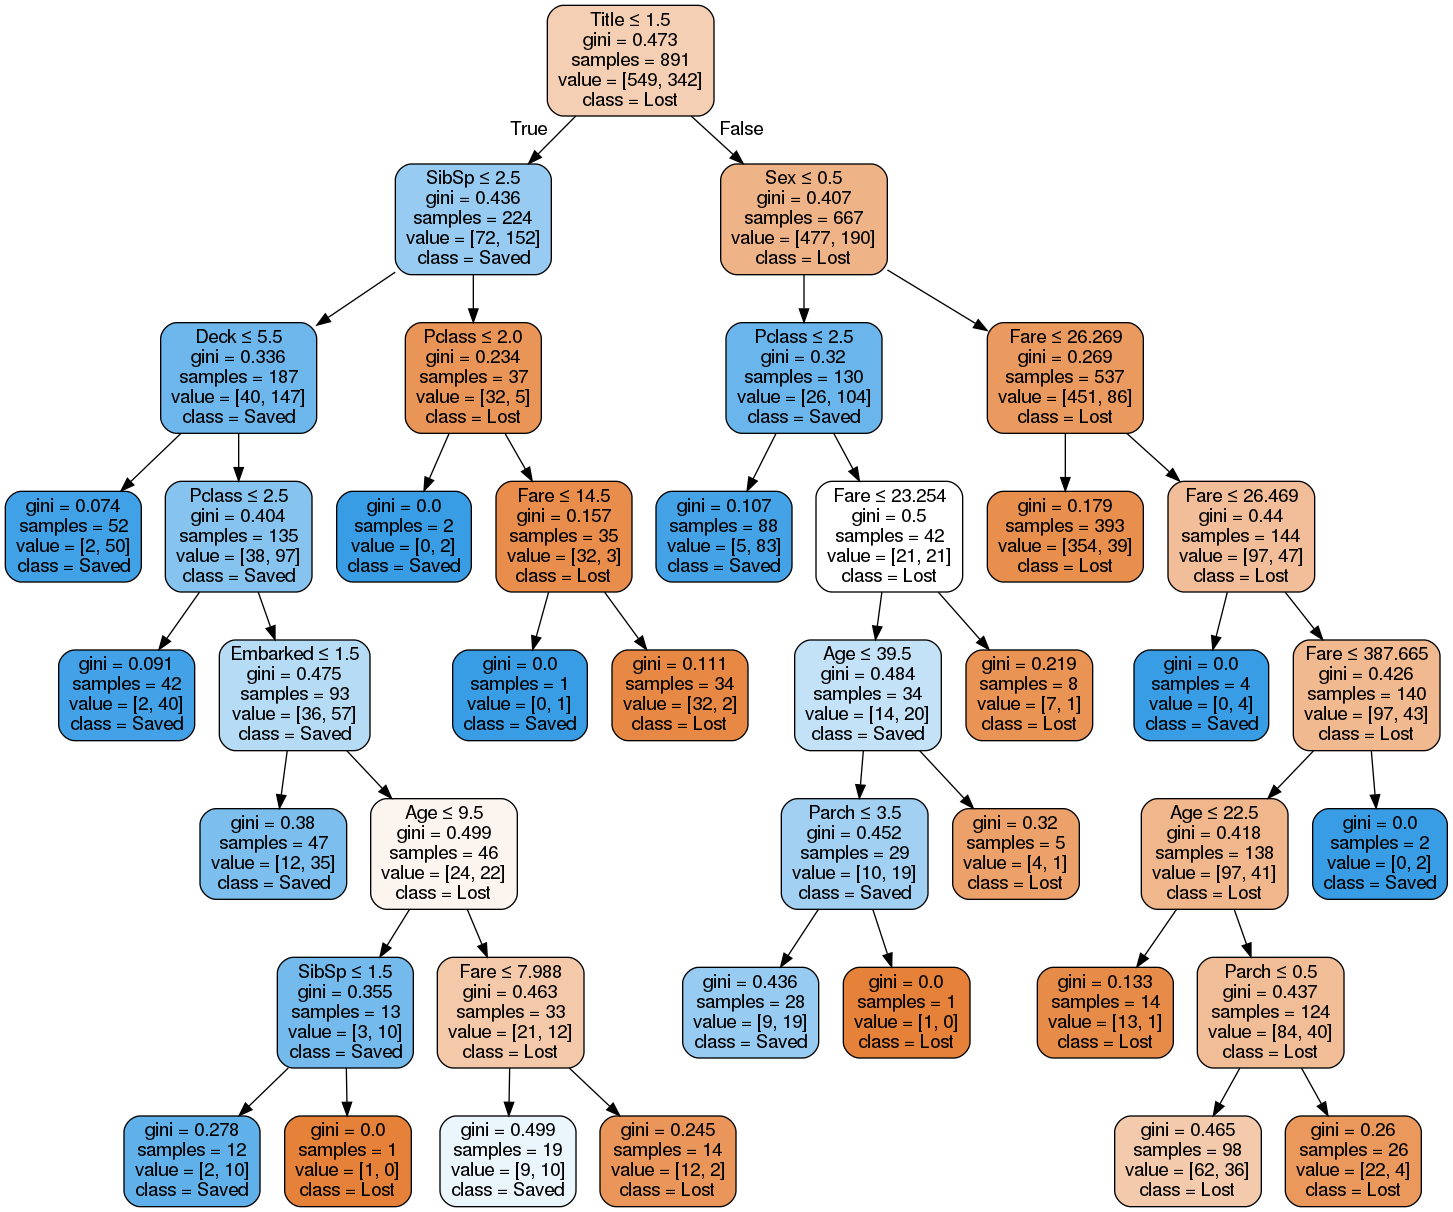

In [41]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns, class_names=['Lost', 'Saved'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Как видим, гаиболее значимыми переменными оказались:
1. Титул (генератив из имени)
2. Количество Братьев/Сестер/Супругов на борту
3. Пол
4. Палуба каюты
5. Цена билета

In [ ]:
import os
os.system('')